In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

# 마케팅 캠페인 데이터셋
* 어떤 특성(피처)을 가진 소비자가 마케팅 캠페인에 더 많이 참여했는지 분석하고자 합니다
* (참고) [캐글](https://www.kaggle.com/rodsaldanha/arketing-campaign) 


In [2]:
base_path = ""
marketing = pd.read_csv(base_path + "marketing_campaign.csv", \
                 sep =';')

### 전처리
* (참고) [EDA B조 코드](https://github.com/yonsei-dsl/7th_EDA/blob/main/B%EC%A1%B0/EDA_B%EC%A1%B0_%EC%BD%94%EB%93%9C.ipynb) - 감사합니다 :)

In [3]:
# company에 enrol한 연도, 월 따로 저장
marketing.Dt_Customer = pd.to_datetime(marketing.Dt_Customer)
marketing["enrol_year"] = marketing.Dt_Customer.dt.strftime("%Y")
marketing["enrol_month"] = marketing.Dt_Customer.dt.strftime("%m")

In [4]:
from datetime import datetime
# 현재까지의 회원일수 따로 저장
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))

In [5]:
marketing['days'] = y - marketing.Dt_Customer
marketing['days'] = marketing['days'] / np.timedelta64(1, 'D')
marketing['days'] = marketing['days'].astype(int) # int형으로 변환

In [6]:
# 나이를 age에 저장
marketing['age'] = 2022-marketing['Year_Birth']

In [7]:
marketing.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'enrol_year', 'enrol_month', 'days', 'age'],
      dtype='object')

5차례의 마케팅 캠페인에 총 몇 회 참여했는지에 따라 소비자 군집을 만들고자 합니다 \
 

In [8]:
# 소비자별 총 캠페인 참여 횟수를 구하여 CampaignAttendance에 저장
# (힌트) 'AcceptedCmpN'의 자료형은 ?!
marketing['CampaignAttendance'] = marketing.iloc[:, 20:25].sum(axis = 1)

In [9]:
# 5번의 마케팅 캠페인 모두에 참여한 소비자는 없음
marketing['CampaignAttendance'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

분석을 위해 **연속형 변수**만을 피처로 사용하겠습니다
* (참고) https://www.kaggle.com/ededhiscalifh/marketing-campaign-eda-practice/notebook

In [10]:
ID = ['ID']
features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
label = ['CampaignAttendance'] 

In [11]:
print(len(features),"차원 데이터입니다")

15 차원 데이터입니다


In [12]:
campaign = marketing[ID + features + label]

In [13]:
# 결측값 제거
campaign = campaign.dropna()

In [14]:
campaign.shape 

(2216, 17)

# PCA
* 클러스터링을 수행하기 전에 PCA를 사용해 추후 클러스터링 단계에서 사용할 주성분 개수를 구하도록 하겠습니다
* 주성분 개수는 분산 설명 비율이 90% 이상이 되게끔 하는 값으로 구하겠습니다

In [15]:
# 데이터프레임의 형태로 피처셋과 레이블셋을 할당해주세요
X = campaign.iloc[:, 1:-1]
y = campaign.iloc[:, -1]

In [16]:
# Scaling 먼저 해주세요
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std  = scaler.fit_transform(X)

# 시각화 위해 데이터프레임으로 변환
X_std = pd.DataFrame(X_std, columns=X.columns, index=list(X.index.values))

원본 차원의 수만큼 총 15개의 주성분을 생성하겠습니다

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X_std) # PCA에는 scaling한 데이터를 넣어주어야 합니다

In [18]:
# 데이터프레임 변환
X_pca = pd.DataFrame(data=X_pca) 

In [19]:
# 100%가 되어야 합니다
print("15개의 주성분에 의해 설명되는 분산 비율: ", sum(pca.explained_variance_ratio_))

15개의 주성분에 의해 설명되는 분산 비율:  1.0


In [20]:
# 15개의 주성분을 중요도 순으로 나열합니다
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)

In [21]:
for i in range(len(importanceOfPrincipalComponents)):
    if sum(importanceOfPrincipalComponents.values[0:i]) >= 0.9:
        print(i)
        break

11


총 분산의 90%이상을 잡아내는 주성분의 개수를 구하세요!
* 이후 클러스터링 학습 시 해당 개수만큼 차원 축소한 피처셋을 이용할 겁니다

In [22]:
# 처음 11개 주성분의 중요도
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('처음 2개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:1].sum(axis=1).values)
print('처음 11개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:11-1].sum(axis=1).values)

처음 2개의 주성분에 의해 설명되는 분산 비율:  [0.4971196]
처음 11개의 주성분에 의해 설명되는 분산 비율:  [0.92240072]


In [23]:
# 처음 두 개의 주성분을 이용하여 2차원 평면에 데이터셋의 분포를 나타내겠습니다
def scatterPlot(xDF, yDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index) 
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

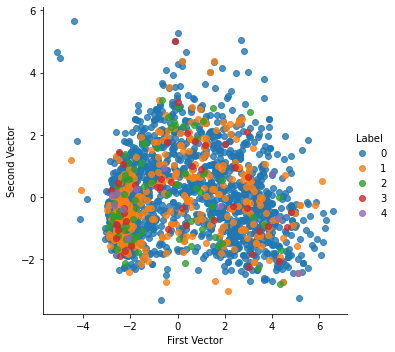

In [24]:
# 설명력이 별로군여 ㅠㅅㅠ
scatterPlot(X_pca, y)

# 클러스터링
* PCA를 통해 구한 상위 $x$개(분산 설명력 90% 이상)의 주성분을 사용하여 클러스터링을 하고자 합니다

In [25]:
from sklearn.cluster import KMeans

In [26]:
# 파라미터를 설정해주세요
n_clusters = 3 # 군집 수 k
n_init = 10 # 초기화 횟수
max_iter = 100 # 학습(군집 재할당)의 반복 횟수
tol = 0.0001 # 너무 오랜 시간 반복하는 경우에 대비해 tol만큼 줄어들지 않으면 조기 종료
random_state = 42

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

In [28]:
# 처음 11개의 주성분만을 이용하고자 합니다
cutoff = 11-1 # 앞서 구한 주성분 개수 - 1
X_train_Kmeans = X_pca.loc[:,0:cutoff]

kmeans = kmeans.fit(X_train_Kmeans)

In [29]:
# 클러스터링 결과 
result = X_train_Kmeans.copy()

result["cluster"] = kmeans.labels_ 

In [30]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,3.792298,1.442685,-1.188701,0.489076,-1.684880,0.657709,0.911433,0.258988,2.131301,-0.506056,-0.368913,0
1,-2.121084,-1.244661,1.428761,-0.257899,-0.726021,-0.087000,0.511487,0.286159,0.250090,0.102382,0.163561,1
2,1.665944,-0.064820,0.500500,-0.966260,-0.201972,-0.423193,-0.890039,-1.063045,-0.446395,-0.379405,-0.011517,0
3,-2.375429,-0.993010,-0.552984,-0.910029,0.775877,-0.579228,0.035769,-0.125336,-0.048974,-0.224105,-0.330867,1
4,-0.066794,0.114334,-0.201885,1.300219,1.315347,-1.331835,1.158915,-0.429790,0.010220,-0.194494,0.355208,2


In [31]:
def ClusteringPlot(xDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,xDF["cluster"]), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "cluster"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="cluster", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

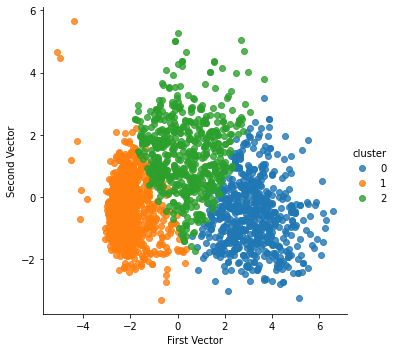

In [32]:
ClusteringPlot(result)

결과물에 대한 해석 한두줄 적어주세요! 수고 많으셨습니다 :)

총 분산이 90% 이상인 상위 11개 변수에 대해서 3개 군집으로 clustering하는 것이 설명력 높음